<a href="https://colab.research.google.com/github/darasliwinski/nlp_disaster/blob/bertweet1/BERTweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install packages
#!pip install ipynb
!pip install import_ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 39.7 MB/s 


In [2]:
import pandas as pd
import numpy as np

# For cleaning the text
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

# For building our model
import tensorflow.keras
import sklearn
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# move to directory where original notebook is stored
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [6]:
# import package and original notebook (as A for easy reference)
import import_ipynb
import nlpDisaster as A

# BERTweet

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 31.3 MB/s 
     |████████████████████████████████| 182 kB 56.9 MB/s 
     |████████████████████████████████| 7.6 MB 58.1 MB/s 


In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

!pip install tensorflow_addons
import tensorflow as tf
import tensorflow_addons as tfa
from transformers import AutoTokenizer,TFRobertaModel
    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.1 MB/s 


In [16]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv') 
df.head()
x = (df['text']
     .str.lower()     
     .str.replace('\x89Ûª|Ûª', "'")
     .str.replace('\n|\x89.|\x9d *', ' ')
     .str.replace('&gt;', ">")
     .str.replace('&lt;', "<")
     .str.replace('&amp;', " and ")
     .str.replace('won\'t', 'will not')
     .str.replace('can\'t', 'cannot')
     .str.replace('i\'m', 'i am')
     .str.replace('ain\'t', 'is not')
     .str.replace('hwy.', 'highway')
     .str.replace('(\w+)\'ll', '\g<1> will')
     .str.replace('(\w+)n\'t', '\g<1> not')
     .str.replace('(\w+)\'ve', '\g<1> have')
     .str.replace('(\w+)\'s', '\g<1> is')
     .str.replace('(\w+)\'re', '\g<1> are')
     .str.replace('(\w+)\'d', '\g<1> would')     
     .str.replace('(\w+)\'m', '\g<1> am')
     .str.replace('<3', 'love')
     .str.replace('w/e', 'whatever')
     .str.replace('w/', 'with')    
     .str.replace('\b', ' ')
     .str.replace('-', ' ')
     .str.replace('  *', ' ')
     .str.strip()
     .to_numpy()
    )
y = df['target'].to_numpy()

#x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.7, random_state = 1000)

In [31]:
y.shape()

TypeError: ignored

# Tokenizer

Download from HuggingFace
This tokenizer was trained on millions of tweets unrelated to this task.

In [11]:
!pip install emoji==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 7.1 MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49735 sha256=236168995f818de98c2949e31e06a13071e1461c880825628743f6d17e83c495
  Stored in directory: /root/.cache/pip/wheels/4e/bf/6b/2e22b3708d14bf6384f862db539b044d6931bd6b14ad3c9adc
Successfully built emoji


In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [35]:
print(x_train.shape)

(6471,)


In [36]:
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', 
                                          normalization=True, 
                                          use_fast = False,
                                          add_special_tokens=True,
                                          pad_to_max_length=True,
                                          return_attention_mask=True)

train_token = tokenizer(x_train.tolist(), 
                    padding="max_length", 
                    truncation=True,
                    return_tensors = 'tf').data
val_token = tokenizer(x_val.tolist(), 
                    padding="max_length", 
                    truncation=True,
                    return_tensors = 'tf').data

train_features = {x: train_token[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, y_train))
train_tf_dataset = train_tf_dataset.shuffle(len(x_train)).batch(32).prefetch(tf.data.AUTOTUNE)

val_features = {x: val_token[x] for x in tokenizer.model_input_names}
val_tf_dataset = tf.data.Dataset.from_tensor_slices((val_features, y_val))
val_tf_dataset = val_tf_dataset.shuffle(len(x_val)).batch(32).prefetch(tf.data.AUTOTUNE)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Train
Take the matching transformer model and append a simple feed forward network

In [37]:
!pip install Strategy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement Strategy (from versions: none)
ERROR: No matching distribution found for Strategy


In [38]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():  
    bert_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

def build_model(hidden_n, drop = 0.3, lr = 1e-5, weight_decay = 1e-6):
    with strategy.scope():    
        input_ids = tf.keras.Input(shape=(128,),dtype='int32', name = 'input_ids')
        attention_masks = tf.keras.Input(shape=(128,),dtype='int32', name = 'attention_mask')

        output = bert_model([input_ids,attention_masks])[1]
        output = tf.keras.layers.Dense(hidden_n,activation='relu')(output)
        output = tf.keras.layers.Dropout(drop)(output)
        output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

        model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

        f1_score = tfa.metrics.F1Score(1, threshold = 0.5)
        model.compile(tfa.optimizers.AdamW(weight_decay = weight_decay, lr=lr), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', f1_score])

        # Prevent training the transformer from training again
        model.layers[2].trainable = False
        
        return model

Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [39]:
grid = [{'hidden_n': 16, 'drop': 0.3, 'lr': 1e-5, 'weight_decay': 1e-6},
        {'hidden_n': 32, 'drop': 0.3, 'lr': 1e-5, 'weight_decay': 1e-6},
        {'hidden_n': 32, 'drop': 0.3, 'lr': 5e-6, 'weight_decay': 1e-6},
        {'hidden_n': 32, 'drop': 0.25, 'lr': 1e-5, 'weight_decay': 5e-6},,#best val f1
        {'hidden_n': 32, 'drop': 0.35, 'lr': 1e-5, 'weight_decay': 5e-7}
        {'hidden_n': 64, 'drop': 0.3, 'lr': 1e-5, 'weight_decay': 1e-6},
        {'hidden_n': 64, 'drop': 0.3, 'lr': 1e-5, 'weight_decay': 5e-6},
       ]

def run_loop(**kwargs):
    model = build_model(**kwargs)
    history = model.fit(train_tf_dataset,
                        validation_data = val_tf_dataset,
                        epochs = 2)
    return {**kwargs, 'model': model, 'f1': history.history['val_f1_score'][-1][0]}

results = [run_loop(**params) for params in grid]

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/2


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


203/203 [==============================] - 195s 863ms/step - loss: 0.5013 - accuracy: 0.7767 - f1_score: 0.7124 - val_loss: 0.3919 - val_accuracy: 0.8336 - val_f1_score: 0.7948
Epoch 2/2
203/203 [==============================] - 171s 843ms/step - loss: 0.3727 - accuracy: 0.8594 - f1_score: 0.8247 - val_loss: 0.3856 - val_accuracy: 0.8529 - val_f1_score: 0.8158
Epoch 1/2
203/203 [==============================] - 86s 355ms/step - loss: 0.6224 - accuracy: 0.6084 - f1_score: 0.1686 - val_loss: 0.5577 - val_accuracy: 0.7110 - val_f1_score: 0.4954
Epoch 2/2
203/203 [==============================] - 67s 329ms/step - loss: 0.5028 - accuracy: 0.7921 - f1_score: 0.6882 - val_loss: 0.4641 - val_accuracy: 0.8441 - val_f1_score: 0.7916
Epoch 1/2
203/203 [==============================] - 86s 355ms/step - loss: 0.6142 - accuracy: 0.7450 - f1_score: 0.7141 - val_loss: 0.5737 - val_accuracy: 0.8319 - val_f1_score: 0.7913
Epoch 2/2
203/203 [==============================] - 67s 328ms/step - loss: 0.

In [42]:
results = pd.DataFrame(results).sort_values('f1', ascending=False)
model = results.model[1]

results
#Epoch 2/2
#203/203 [==============================] - 67s 329ms/step - loss: 0.4696 - accuracy: 0.8703 - f1_score: 0.8360 - val_loss: 0.4311 - val_accuracy: 0.8529 - val_f1_score: 0.8182

,hidden_n,drop,lr,weight_decay,model,f1
3,32,0.25,0.000010,5.000000e-06,<keras.engine.functional.Functional object at 0x7fe2ed31b210>,0.818182
5,64,0.30,0.000010,1.000000e-06,<keras.engine.functional.Functional object at 0x7fe2e2312590>,0.816777
0,16,0.30,0.000010,1.000000e-06,<keras.engine.functional.Functional object at 0x7fe507733810>,0.815789
4,32,0.35,0.000010,5.000000e-07,<keras.engine.functional.Functional object at 0x7fe2e820a4d0>,0.815145
6,64,0.30,0.000010,5.000000e-06,<keras.engine.functional.Functional object at 0x7fe2da90ec90>,0.812095
2,32,0.30,0.000005,1.000000e-06,<keras.engine.functional.Functional object at 0x7fe4712f8110>,0.807947
1,32,0.30,0.000010,1.000000e-06,<keras.engine.functional.Functional object at 0x7fe50772a4d0>,0.791569


In [105]:
results.model[1].metrics

In [70]:
testing_df = pd.DataFrame(x_test, y_test)
token = tokenizer(x_test.tolist(), 
                  padding="max_length", 
                  truncation=True,
                  return_tensors = 'tf').data




In [93]:
testing_df =pd.concat([pd.DataFrame(x_test), pd.DataFrame(y_test)],axis = 1)
testing_df.columns = ['text', 'target']

In [94]:
preds = model.predict(token)

#testing_df['target'] = (df['p'] > 0.5).astype(int)

18/18 [==============================] - 5s 272ms/step


In [113]:
preds[0][0]

0.61500734

In [95]:
testing_df['p'] = ''
for i in range(len(testing_df)):
  testing_df["p"][i] = preds[i][0]
               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
testing_df['target_pred'] = (testing_df['p'] > 0.5).astype(int)

In [97]:

testing_df

,text,target,p,target_pred
0,over half of poll respondents worry nuclear disaster fading from public consciousness http://t.co/ytnnnd631z ##fukushima,0,0.615007,1
1,that horrible sinking feeling when you ªve been at home on your phone for a while and you realise its been on 3g this whole time,1,0.197925,0
2,@davidcovucci we cannot because a sinkhole swallowed every taco place in the neighborhood,0,0.545857,1
3,a wasp just dive bombed my face,0,0.256245,0
4,133 n past the 5 l lane is reopened. all other lanes are closed. all lanes are open on the 133 s. trash truck fire cleanup. @knx1070,1,0.64543,1
...,...,...,...,...
566,someone split a mudslide w me when i get off work,0,0.168821,0
567,breakfast links: work from home: derailed: an empty train derailed at smithsonian this morning suspending ser... http://t.co/id4qgqdnjq,1,0.679854,1
568,rocky fire in northern california swells to 60000 acres; 12000 evacuated http://t.co/mtfnbhryzq portland #phoenix #miami #atlanta #casper,1,0.682984,1
569,i get this feeling that society will collapse or implode. so do not be a hero and play your part.,0,0.211926,0


In [99]:
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy

In [100]:
compute_accuracy(testing_df['target'], testing_df['target_pred'])

0.8178633975481612

In [117]:
	
metrics.roc_auc_score(testing_df['target'], testing_df['target_pred'])

0.7970168855534709

In [106]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testing_df['target'], testing_df['target_pred'])

array([[308,  17],
       [ 87, 159]])

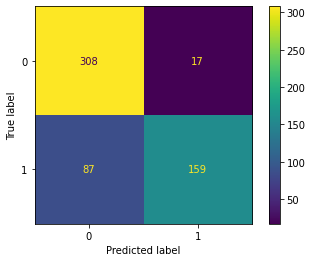

In [114]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(testing_df['target'], testing_df['target_pred'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [ ]:
test_df.valuecount